In [2]:
import pixiedust
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import requests
import urllib3


In [3]:
# The code was removed by Watson Studio for sharing.

[Row(id='7129300520', date='20141013T000000', price='221900', bedrooms='3', bathrooms='1', sqft_living='1180', sqft_lot='5650', floors='1', waterfront='0', view='0', condition='3', grade='7', sqft_above='1180', sqft_basement='0', yr_built='1955', yr_renovated='0', zipcode='98178', lat='47.5112', long='-122.257', sqft_living15='1340', sqft_lot15='5650'),
 Row(id='6414100192', date='20141209T000000', price='538000', bedrooms='3', bathrooms='2.25', sqft_living='2570', sqft_lot='7242', floors='2', waterfront='0', view='0', condition='3', grade='7', sqft_above='2170', sqft_basement='400', yr_built='1951', yr_renovated='1991', zipcode='98125', lat='47.721', long='-122.319', sqft_living15='1690', sqft_lot15='7639'),
 Row(id='5631500400', date='20150225T000000', price='180000', bedrooms='2', bathrooms='1', sqft_living='770', sqft_lot='10000', floors='1', waterfront='0', view='0', condition='3', grade='6', sqft_above='770', sqft_basement='0', yr_built='1933', yr_renovated='0', zipcode='98028', 

In [4]:
%matplotlib inline

In [7]:
from pyspark.sql.types import DoubleType
df = df.withColumn("sqft_living", df["sqft_living"].cast(DoubleType()))
df = df.withColumn("price", df["price"].cast(DoubleType()))
df = df.withColumn("bedrooms", df["bedrooms"].cast(DoubleType()))
df = df.withColumn("bathrooms", df["bathrooms"].cast(DoubleType()))
df = df.withColumn("floors", df["floors"].cast(DoubleType()))

In [9]:
data = df.toPandas()

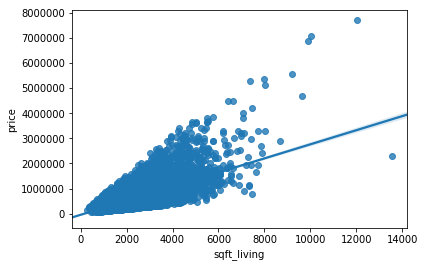

In [10]:
# Visualizing Linear relationship using regplot

sns.regplot(x='sqft_living',y='price', data=data)

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [12]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: double (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



In [13]:
assembler = VectorAssembler(inputCols=['sqft_living','bedrooms','bathrooms','floors'],outputCol="features")
lr = LinearRegression(labelCol='price', featuresCol='features')

pipeline = Pipeline(stages=[assembler, lr])

model = pipeline.fit(df)

In [16]:
def get_prediction(square_feet, num_bedrooms,num_bathrooms,num_floors):
    request_df = spark.createDataFrame([(square_feet, num_bedrooms, num_bathrooms,num_floors)], ['sqft_living','bedrooms','bathrooms','floors'])
    response_df = model.transform(request_df)
    return response_df


In [17]:

#testing the prediction function

response = get_prediction(1000, 4,1,2)
response.show()

+-----------+--------+---------+------+--------------------+-----------------+
|sqft_living|bedrooms|bathrooms|floors|            features|       prediction|
+-----------+--------+---------+------+--------------------+-----------------+
|       1000|       4|        1|     2|[1000.0,4.0,1.0,2.0]|160925.5623600583|
+-----------+--------+---------+------+--------------------+-----------------+



In [18]:
service_path = 'https://eu-gb.ml.cloud.ibm.com'
username="8f0e01f2-b456-4e8c-9f72-c0583f584efd"
instance_id= "5107e0f5-a5c4-4bc6-a8c5-2e1cc884646e"
password= "525a7547-f68e-4abc-be50-7842e6565941"
model_name = 'House Prices Model'
deployment_name = 'House Prices Deployment'

In [19]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact
ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

In [20]:
pipeline_artifact = MLRepositoryArtifact(pipeline, name="pipeline")
model_artifact = MLRepositoryArtifact(model, training_data=df, name=model_name, pipeline_artifact=pipeline_artifact)

saved_model = ml_repository_client.models.save(model_artifact)
model_id = saved_model.uid


In [21]:
headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
url = '{}/v3/identity/token'.format(service_path)
response = requests.get(url, headers=headers)
ml_token = 'Bearer ' + json.loads(response.text).get('token')

In [22]:
deployment_url = service_path + "/v3/wml_instances/" + instance_id + "/published_models/" + model_id + "/deployments/"
deployment_header = {'Content-Type': 'application/json', 'Authorization': ml_token}
deployment_payload = {"type": "online", "name": deployment_name}

deployment_response = requests.post(deployment_url, json=deployment_payload, headers=deployment_header)
deployment_response.text
scoring_url = json.loads(deployment_response.text).get('entity').get('scoring_url')
scoring_url

'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/5107e0f5-a5c4-4bc6-a8c5-2e1cc884646e/published_models/4fb9e334-786c-4a5f-9f3c-fe6d4eb43f45/deployments/5b65930b-5684-4228-a0aa-f416673add67/online'

In [23]:
def get_prediction_from_watson_ml(square_feet, num_bedrooms,num_bathrooms,num_floors):
    scoring_header = {'Content-Type': 'application/json', 'Authorization': ml_token}
    scoring_payload = {'fields': ['sqft_living','bedrooms','bathrooms','floors'], 'values': [[square_feet, num_bedrooms,num_bathrooms,num_floors]]}
    scoring_response = requests.post(scoring_url, json=scoring_payload, headers=scoring_header)
    return scoring_response.text

In [25]:
#evaluation

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="rmse")



In [32]:
predictions = model.transform(df)

In [27]:
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 257790


In [38]:
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("r2: %.3f" %r2)

MSE: 66455438852.308
MAE: 170276.080
r2: 0.507


Text(0.5,1,'Correlation between features')

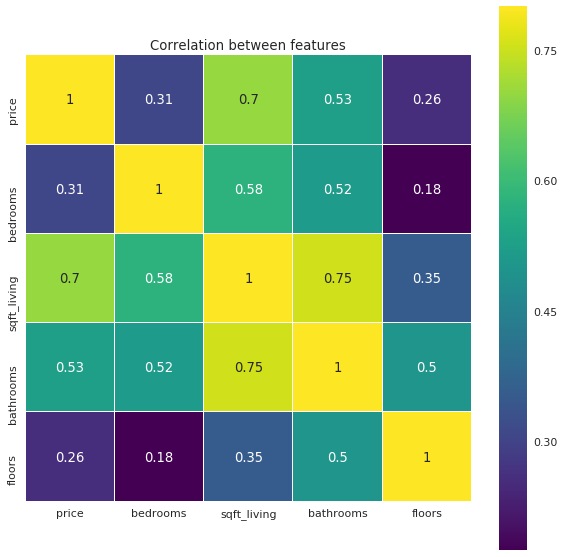

In [30]:
corrMatrix=data[["price","bedrooms","sqft_living","bathrooms","floors","yr_built","yr_renovated","sqft_lot","sqft_basement","grade","condition"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features')

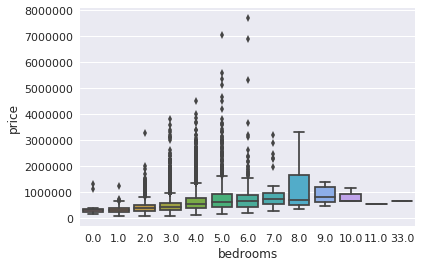

In [39]:
sns.boxplot("bedrooms","price",data=data);
